# `modtox.DataSet`

A dataset is created from the returned dataframe obtained from `modtox.Collection.to_dataframe()`. Preparation of the dataset consists in preprocessing the data for feeding it into the ML model.

There is a wrapper function `modtox.DataSet.transform()` that performs all of the preprocessing. The parameters for this function are:
- `outliers_threshold`: `int` if cluster members < outliers threshold, all members of said cluster are considered outliers.
- `resampling_method`: 'oversampling' randomly duplicates molecules from the smaller set. 'undersampling' randomly removes molecules from the bigger set. 'none' does not remove/add any molecules.
- `scaling_method`: 'normalize', 'standarize' or 'none'.



Yields a dictionary with the following key: value pairs: 
- __X_train__: molecules from the train set with the outliers removed.
- __y_train__: labels for X_train.
- __X_test__: molecules from the test set, only scaled and imputed.
- __y_test__: labels for X_test.
- __X_test_reg__: molecules that a) were on the test set and not outliers or b) were removed from the test set by undersampling and are not outliers. 
- __y_test_reg__: labels for X_test_reg
- __X_test_out__: molecules that were either: a) on the test set, b) on the train set but were removed because i) undersampling or ii) were outliers.
- __y_test_out__: labels for X_test_reg

In [1]:
import pandas as pd
import os

from modtox.modtox.ML.dataset import DataSet
target = "3pls"

csv = os.path.join(os.path.abspath(""), "data", target, "mordred_topo_morgan.csv")
df = pd.read_csv(csv, index_col=0)

## Outlier removal performance evaluation
To evaluate the removal of outliers from the train set, different threshold numbers will be set. The clustering parameters are evaluated in `collection.ipynb`. 
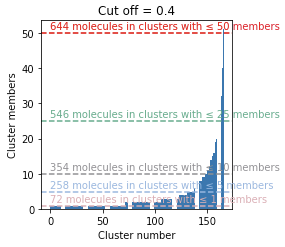
> *Note*: other parameters are set to "none" to assess the individual effect of each parameter. 

So, four a outlier threshold of 1, 72 molecules will be considered outliers. Some of them will be removed from the train set (orphan molecules in the scheme), and the other ones will be in the test set. Finally they will all be recovered in the 'test_set_out' dataframe.

In [2]:
import warnings
warnings.filterwarnings('ignore')  # Ignore pandas warnings in output (copy/slice)
ds = DataSet(df)
dfs = ds.transform(outliers_threshold=1, resampling_method="none", scaling_method="none")

So, the total number of molecules (695) is split in an stratified manner (same proportion of actives/inactives in train and test) between train (499) and test (139). Those two sets will used as usual in any ML approach.  

Apart from that, the test set is also joined with the discarded molecules and is split into a regular testing set (does not contain outliers) and an outlier testing set. 

In [3]:
for k, v in dfs.items():
    print(f"{k}: {v.shape}")

X_train: (116, 4685)
y_train: (116,)
X_test: (69, 4685)
y_test: (69,)
X_test_reg: (28, 4685)
y_test_reg: (28,)
X_test_out: (200, 4685)
y_test_out: (200,)


We will use a the a VotingClassifier without hyperparameter tuning to evaluate each threshold. Without removing outliers from the dataset (threshold = 0).

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef

In [5]:
ds = DataSet(df)
dfs = ds.transform(outliers_threshold=0, resampling_method="none", scaling_method="none")

X_train, y_train = dfs["X_train"], dfs["y_train"]
X_test, y_test = dfs["X_test"], dfs["y_test"]

clf = VotingClassifier(estimators=[
    ("knn", KNeighborsClassifier()),
    ("lr", LogisticRegression()),
    ("svc", SVC()),
    ("tree", DecisionTreeClassifier()),
    ("nb", BernoulliNB())
])

We evaluate the performance of the model by a simple accuracy score. We evaluate the Voting Classifier as well as all the other individual models. For this first example, let's do it without removing outliers.

In [6]:
dfs = ds.transform(outliers_threshold=0, resampling_method="none", scaling_method="none")

X_train, y_train = dfs["X_train"], dfs["y_train"]
X_test, y_test = dfs["X_test"], dfs["y_test"]

fitted_clf = clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

score = [
    False,
    accuracy_score(y_train, y_pred_train),
    accuracy_score(y_test, y_pred_test),
    matthews_corrcoef(y_train, y_pred_train),
    matthews_corrcoef(y_test, y_pred_test)
]
    
ref_score = pd.DataFrame([score], columns=["processed", "train_acc", "test_acc", "train_matt", "test_matt"])

In [7]:
ref_score

,processed,train_acc,test_acc,train_matt,test_matt
0,False,0.901818,0.782609,0.737445,0.388991


Notice how the test scores are clearly below the training ones, the model is clearly underfitting. It is expected because there are a lot of features and we are not tuning the hyperparameters nor reducing the dimensionality.  

Now, let's see the effect of outlier removal:

In [10]:
from tqdm import tqdm
results = dict()
for th in tqdm(range(1, 11)):
    dfs = ds.transform(outliers_threshold=th, resampling_method="none", scaling_method="none")
    
    X_train, y_train = dfs["X_train"], dfs["y_train"]
    X_test, y_test = dfs["X_test"], dfs["y_test"]
    X_test_reg, y_test_reg = dfs["X_test_reg"], dfs["y_test_reg"]
    X_test_out, y_test_out = dfs["X_test_out"], dfs["y_test_out"]
    
    fitted_clf = clf.fit(X_train, y_train)
    scores = {k: dict() for k in ["Train", "Test", "Regulars", "Outliers"]}
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_reg = clf.predict(X_test_reg)
    y_pred_out = clf.predict(X_test_out)
    scores["Train"] = accuracy_score(y_train, y_pred_train)
    scores["Test"] = accuracy_score(y_test, y_pred_test)
    scores["Regulars"] = accuracy_score(y_test_reg, y_pred_reg)
    scores["Outliers"] = accuracy_score(y_test_out, y_pred_out)
    results[th] = scores

100%|██████████| 10/10 [00:42<00:00,  4.24s/it]


In [11]:
outliers_df = pd.DataFrame().from_dict(results, orient="index")

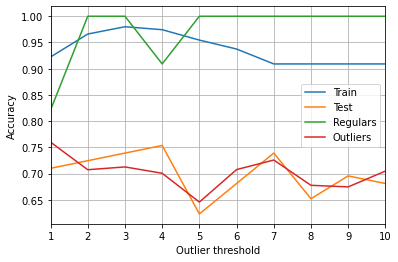

In [13]:
import matplotlib.pyplot as plt
outliers_df.plot(kind="line")
plt.xlabel("Outlier threshold")
plt.ylabel("Accuracy")
plt.xlim(1, 24)
plt.grid()
plt.savefig(f"data/{target}/outliers.png")

Here we can se a trade-off between the regulars accuracy and the outliers accuracy. The more molecules we consider outliers, the better the model will be at classifying regulars and worse to classify outliers (molecules seen by the model will be more similar). 

## Resampling method performance evaluation
Same procedure for evaluating the different resampling techniques.

In [14]:
import warnings
from sklearn.metrics import matthews_corrcoef
warnings.filterwarnings('ignore') # Ignore pandas warnings in output (copy/slice)
scores = list()
for rsmp in tqdm(["undersampling", "oversampling", "none"]):
    ds = DataSet(df)
    dfs = ds.transform(outliers_threshold=0, resampling_method=rsmp, scaling_method="none")
    X_train, y_train = dfs["X_train"], dfs["y_train"]
    X_test, y_test = dfs["X_test"], dfs["y_test"]

    fitted_clf = clf.fit(X_train, y_train)
    
    y_pred_train = fitted_clf.predict(X_train)
    y_pred_test = fitted_clf.predict(X_test)
    
    scores.append([
        rsmp, 
        accuracy_score(y_train, y_pred_train),
        accuracy_score(y_test, y_pred_test),
        matthews_corrcoef(y_train, y_pred_train),
        matthews_corrcoef(y_test, y_pred_test)
    ])
    
rsmp_scores = pd.DataFrame(scores, columns=["method", "train_acc", "test_acc", "train_matt", "test_matt"])


100%|██████████| 3/3 [00:15<00:00,  5.19s/it]


In [15]:
rsmp_scores

,method,train_acc,test_acc,train_matt,test_matt
0,undersampling,0.809859,0.695652,0.619780,0.453507
1,oversampling,0.884804,0.710145,0.779879,0.440266
2,none,0.901818,0.797101,0.737445,0.438894


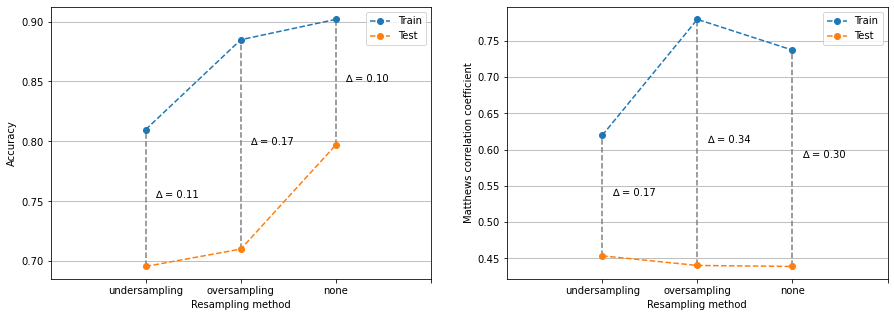

In [16]:
import matplotlib.pyplot as plt

xlab = "Resampling method"
methods = ["undersampling", "oversampling", "none"]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sc = rsmp_scores[["method", "train_acc", "test_acc"]]
sc.plot(
    x="method", 
    marker="o", 
    linestyle="--", 
    xlim=(-1, 3), 
    xticks=[0, 1, 2, 3, 4], 
    xlabel=xlab, 
    ylabel="Accuracy",
    ax=axs[0]
)
axs[0].legend(["Train", "Test"])
axs[0].grid(axis="y")
for i, met in enumerate(methods):
    test = sc[sc["method"] == met]["test_acc"]
    train = sc[sc["method"] == met]["train_acc"]
    diff = float(train-test)
    axs[0].vlines(x=i, ymin=test, ymax=train, color="gray", linestyle="--")
    axs[0].text(x=i+0.1, y=test + diff/2, s=f"∆ = {diff:.2f}")

sc = rsmp_scores[["method", "train_matt", "test_matt"]]
sc.plot(
    x="method", 
    marker="o", 
    linestyle="--", 
    xlim=(-1, 3), 
    xticks=[0, 1, 2, 3, 4], 
    xlabel=xlab, 
    ylabel="Matthews correlation coefficient",
    ax=axs[1]
)
axs[1].legend(["Train", "Test"])
axs[1].grid(axis="y")
for i, met in enumerate(methods):
    test = sc[sc["method"] == met]["test_matt"]
    train = sc[sc["method"] == met]["train_matt"]
    diff = float(train-test)
    axs[1].vlines(x=i, ymin=test, ymax=train, color="gray", linestyle="--")
    axs[1].text(x=i+0.1, y=test + diff/2, s=f"∆ = {diff:.2f}")
plt.savefig(f"data/{target}/resampling.png")

In this example, it seems that neither under or oversampling improve the model.

## Scaling method evaluation performance
ML algorithms usually work better with scaled data. Let's test that:

In [17]:
import warnings
warnings.filterwarnings('ignore') # Ignore pandas warnings in output (copy/slice)
scores = list()
for scl in tqdm(["standarize", "normalize", "none"]):
    ds = DataSet(df)
    dfs = ds.transform(outliers_threshold=0, resampling_method="none", scaling_method=scl)
    X_train, y_train = dfs["X_train"], dfs["y_train"]
    X_test, y_test = dfs["X_test"], dfs["y_test"]

    fitted_clf = clf.fit(X_train, y_train)
    y_pred_train = fitted_clf.predict(X_train)
    y_pred_test = fitted_clf.predict(X_test)
    
    scores.append([
        scl, 
        accuracy_score(y_train, y_pred_train),
        accuracy_score(y_test, y_pred_test),
        matthews_corrcoef(y_train, y_pred_train),
        matthews_corrcoef(y_test, y_pred_test)
    ])
    
scl_scores = pd.DataFrame(scores, columns=["method", "train_acc", "test_acc", "train_matt", "test_matt"])


100%|██████████| 3/3 [00:13<00:00,  4.50s/it]


In [18]:
scl_scores

,method,train_acc,test_acc,train_matt,test_matt
0,standarize,0.974545,0.811594,0.933544,0.502864
1,normalize,0.952727,0.840580,0.874749,0.579459
2,none,0.901818,0.768116,0.737445,0.377420


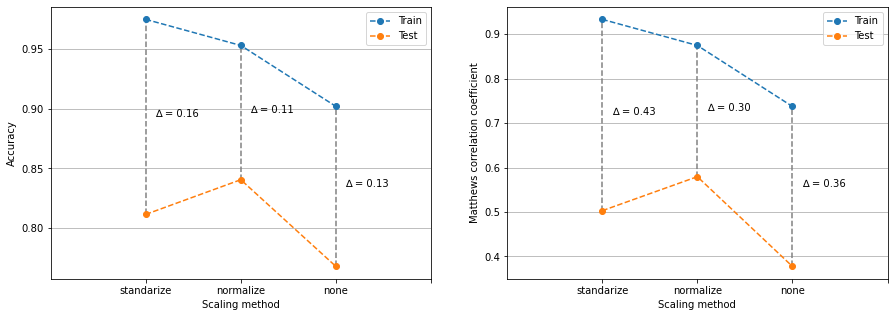

In [19]:
import matplotlib.pyplot as plt

xlab = "Scaling method"
methods = ["standarize", "normalize", "none"]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sc = scl_scores[["method", "train_acc", "test_acc"]]
sc.plot(
    x="method", 
    marker="o", 
    linestyle="--", 
    xlim=(-1, 3), 
    xticks=[0, 1, 2, 3, 4], 
    xlabel=xlab, 
    ylabel="Accuracy",
    ax=axs[0]
)
axs[0].legend(["Train", "Test"])
axs[0].grid(axis="y")
for i, met in enumerate(methods):
    test = sc[sc["method"] == met]["test_acc"]
    train = sc[sc["method"] == met]["train_acc"]
    diff = float(train-test)
    axs[0].vlines(x=i, ymin=test, ymax=train, color="gray", linestyle="--")
    axs[0].text(x=i+0.1, y=test + diff/2, s=f"∆ = {diff:.2f}")

sc = scl_scores[["method", "train_matt", "test_matt"]]
sc.plot(
    x="method", 
    marker="o", 
    linestyle="--", 
    xlim=(-1, 3), 
    xticks=[0, 1, 2, 3, 4], 
    xlabel=xlab, 
    ylabel="Matthews correlation coefficient",
    ax=axs[1]
)
axs[1].legend(["Train", "Test"])
axs[1].grid(axis="y")
for i, met in enumerate(methods):
    test = sc[sc["method"] == met]["test_matt"]
    train = sc[sc["method"] == met]["train_matt"]
    diff = float(train-test)
    axs[1].vlines(x=i, ymin=test, ymax=train, color="gray", linestyle="--")
    axs[1].text(x=i+0.1, y=test + diff/2, s=f"∆ = {diff:.2f}")
plt.savefig(f"data/{target}/scaling.png")

As expected, the model improves significantly after scaling the data. Now, the model is fitting a little better. Cumulative effect:

In [20]:
ds = DataSet(df)
dfs = ds.transform(outliers_threshold=10, resampling_method="oversampling", scaling_method="standarize")
X_train, y_train = dfs["X_train"], dfs["y_train"]
X_test, y_test = dfs["X_test"], dfs["y_test"]

fitted_clf = clf.fit(X_train, y_train)

y_pred_train = fitted_clf.predict(X_train)
y_pred_test = fitted_clf.predict(X_test)
    
score = [
    True,
    accuracy_score(y_train, y_pred_train),
    accuracy_score(y_test, y_pred_test),
    matthews_corrcoef(y_train, y_pred_train),
    matthews_corrcoef(y_test, y_pred_test)
]
    
cum_score = pd.DataFrame([score], columns=["processed", "train_acc", "test_acc", "train_matt", "test_matt"])

In [21]:
summ = cum_score.append(ref_score)
summ = summ.append(rsmp_scores)
summ.append(scl_scores).sort_values("test_acc", ascending=False)

,processed,train_acc,test_acc,train_matt,test_matt,method
1,NaN,0.952727,0.840580,0.874749,0.579459,normalize
0,NaN,0.974545,0.811594,0.933544,0.502864,standarize
2,NaN,0.901818,0.797101,0.737445,0.438894,none
0,False,0.901818,0.782609,0.737445,0.388991,NaN
2,NaN,0.901818,0.768116,0.737445,0.377420,none
1,NaN,0.884804,0.710145,0.779879,0.440266,oversampling
0,NaN,0.809859,0.695652,0.619780,0.453507,undersampling
0,True,1.000000,0.666667,1.000000,0.086976,NaN


The effect is not additive. Let's now check all possible combinations between:
- `outlier_threshold` = 0, 2, 4, 6, 8, 10
- `resampling_method` = undersampling, oversampling and none
- `scaling_method` = normalize, standarize and none

In total, 54 combinations.

In [23]:
import itertools
from sklearn.metrics import matthews_corrcoef
combinations = itertools.product(list(range(0, 7, 2)), 
                                  ["undersampling", "oversampling", "none"], 
                                  ["standarize", "normalize", "none"])
scores = list()
for comb in tqdm(combinations):
    ds = DataSet(df)
    dfs = ds.transform(outliers_threshold=comb[0], resampling_method=comb[1], scaling_method=comb[2])
    
    X_train, y_train = dfs["X_train"], dfs["y_train"]
    X_test, y_test = dfs["X_test"], dfs["y_test"]

    fitted_clf = clf.fit(X_train, y_train)

    y_pred_train = fitted_clf.predict(X_train)
    y_pred_test = fitted_clf.predict(X_test)
    scores.append([
        comb[0],
        comb[1],
        comb[2],
        accuracy_score(y_train, y_pred_train),
        accuracy_score(y_test, y_pred_test),
        matthews_corrcoef(y_train, y_pred_train),
        matthews_corrcoef(y_test, y_pred_test)
    ])
score_df = pd.DataFrame(scores, columns=["out_threshold", "resampling", "scaling","acc_train", "acc_test", "matt_train", "matt_test"])

27it [02:27,  5.45s/it]


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 5

In [ ]:
score_df.sort_values("acc_test", ascending=False).head(5)

In [ ]:
score_df.sort_values("matt_test", ascending=False).head(5)

In [ ]:
score_df.to_csv(f"data/{target}/preprocessing.csv")

In this case, it seems that the best performing dataset is without resampling nor outlier removal, and normalizing. It is important that here we are not selecting for outlier/regular performance.